In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import wandb
import xarray
from dataset.dataset import ImageDataset, valid_test_split, SeviriDataset, pickle_read
from dataset.station_dataset import GroundstationDataset
from dataset.normalization import MinMax, ZeroMinMax
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.plugins.environments import SLURMEnvironment
from lightning.pytorch.utilities import rank_zero_only
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout
from models.FCN import residual_FCN
from models.LightningModule import LitEstimator, LitEstimatorPoint
from tqdm import tqdm

# from pytorch_lightning.pytorch.callbacks import DeviceStatsMonitor
from utils.plotting import best_worst_plot, prediction_error_plot
from utils.etc import benchmark

In [2]:
from dask.distributed import Client
client = Client()

2024-03-25 10:39:56,444 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37739'.
2024-03-25 10:39:56,449 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:38437'.


In [3]:
from types import SimpleNamespace

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    # Compute related
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 1,
    # 'STRATEGY': "ddp",
    'PRECISION': "32",
}
config = SimpleNamespace(**config)

In [4]:
timeindex = pd.DatetimeIndex(pickle_read('/scratch/snx3000/kschuurm/ZARR/timeindices.pkl'))
# timeindex = timeindex[(timeindex.hour >10) & (timeindex.hour <17)]
traintimeindex = timeindex[(timeindex.year >= 2017)]
validtimeindex = timeindex[(timeindex.year  == 2016)]

train_dataset = SeviriDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=2048,
    timeindices=traintimeindex,
    rng = np.random.default_rng(seed=420)
)
valid_dataset = SeviriDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=2048,
    timeindices=validtimeindex,
    seed=0,
)

In [5]:
X, x, y = train_dataset[0]
print(X.shape, x.shape, y.shape)


torch.Size([2048, 12, 15, 15]) torch.Size([2048, 5]) torch.Size([2048, 1])


In [6]:
# model = ConvResNet(
#     num_attr=len(config.x_features),
#     input_channels=len(config.x_vars),
#     output_channels=len(config.y_vars),
# )

model = residual_FCN(
    patch_size = (config.patch_size['x'], config.patch_size['y']),
    input_channels = len(config.x_vars),
    input_features = len(config.x_features),
    channel_size=512,
    output_channels = len(config.y_vars),
)

In [10]:

early_stopping = EarlyStopping('val_loss')


wandb_logger = WandbLogger(project="SIS_point_estimation", log_model=True)

if rank_zero_only.rank == 0:  # only update the wandb.config on the rank 0 process
    wandb_logger.experiment.config.update(vars(config))

mc_station = ModelCheckpoint(
    every_n_epochs=10, save_top_k = 1
)
mc_sarah = ModelCheckpoint(
    every_n_epochs=1, save_top_k = 1
) 

# trainer_station = Trainer(
#     # profiler="simple",
#     # fast_dev_run=True,
#     # num_sanity_val_steps=2,
#     logger=wandb_logger,
#     accelerator=ACCELERATOR,
#     devices=DEVICES,
#     min_epochs=1,
#     max_epochs=100,
#     precision=PRECISION,
#     log_every_n_steps=500,
#     check_val_every_n_epoch=5,
#     callbacks=[early_stopping, mc],
# )


trainer_sarah = Trainer(
    logger=wandb_logger,
    accelerator=config.ACCELERATOR,
    devices=config.DEVICES,
    min_epochs=1,
    max_epochs=35,
    precision=config.PRECISION,
    log_every_n_steps=500,
    # val_check_interval=1,
    callbacks=[early_stopping, mc_sarah],
    max_time="00:02:00:00"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krschuurman. Use `wandb login --relogin` to force relogin


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
train_dataloaders = DataLoader(train_dataset, shuffle=True, batch_size=None, num_workers=0)
valid_dataloaders = DataLoader(valid_dataset, shuffle=False, batch_size=None, num_workers=0)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | residual_FCN     | 298 K 
1 | metric        | MeanSquaredError | 0     
2 | other_metrics | MetricCollection | 0     
---------------------------------------------------
298 K     Trainable params
0         Non-trainable params
298 K     Total params
1.192     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1198: overflow encountered in square
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
2024-03-25 10:39:56,440 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/worker.py", line 1256, in heartbeat
    response = await retry_operation(
  File "/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/scratch/snx3000/

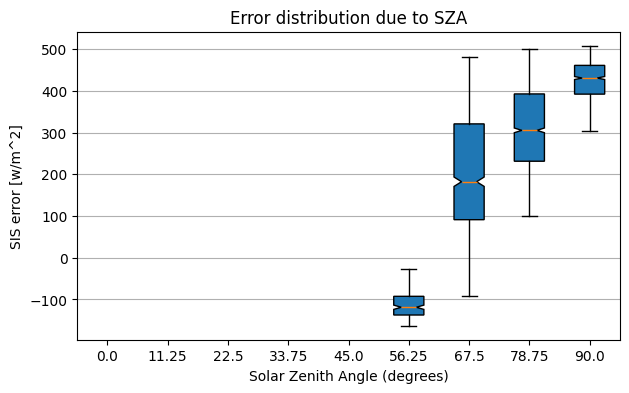

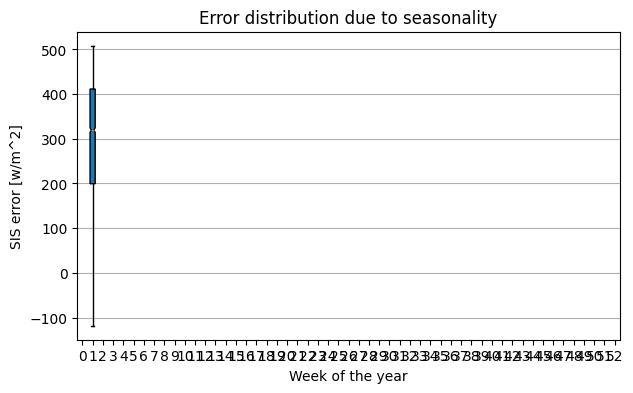

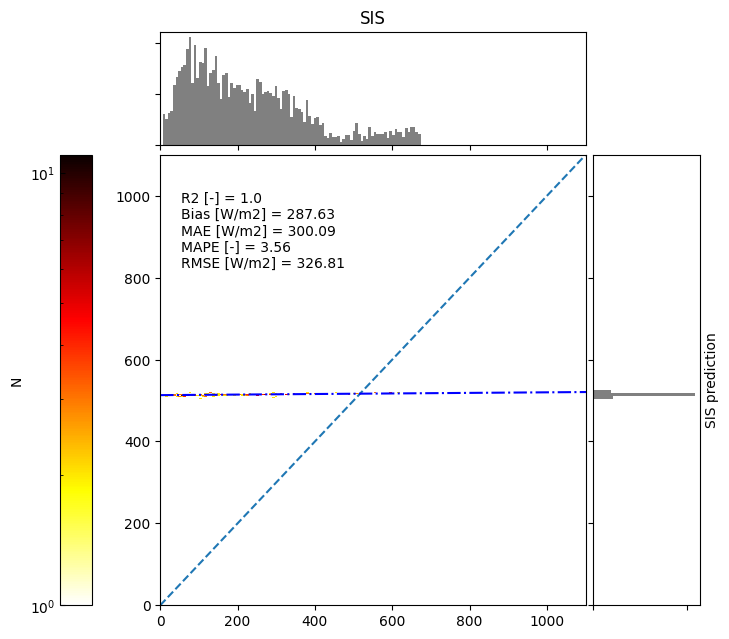

2024-03-25 10:39:58,443 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-03-25 10:39:58,443 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-03-25 10:39:58,444 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/opt/python/3.9.4.1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/python/3.9.4.1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/nanny.py", line 1014, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
Traceback (mo

In [11]:

estimator = LitEstimatorPoint(
    model=model,
    learning_rate=0.0001,
    config=config,
)
trainer_sarah.fit(
    estimator, train_dataloaders=train_dataloaders, val_dataloaders=valid_dataloaders,
    # ckpt_path='/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/tt2pie1v/checkpoints/epoch=30-step=4020.ckpt'
)

In [ ]:
stations = ['CAB', 'CAR', 'CEN' ,'MIL', 'NOR', 'PAL', 'PAY', 'TAB', 'TOR', 'VIS']

test_datasets = [GroundstationDataset(nm, 
                                      config.y_vars, 
                                      config.x_vars, 
                                      config.x_features, 
                                      patch_size=15,
                                      transform=config.transform,
                                      target_transform=config.target_transform) 
                 for nm in stations] 

In [ ]:
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

train_ds, valid_ds = random_split(test_dataset, [0.7, 0.3])

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers= 5)
valid_dl = DataLoader(valid_ds, batch_size=2048, shuffle=False, num_workers=5)

In [ ]:
estimator = LitEstimatorPoint(
    model=model,
    learning_rate=0.001,
    config=config,
)
trainer.fit(
    estimator, train_dataloaders=train_dl, val_dataloaders=valid_dl
)

In [ ]:

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10000, shuffle=False, num_workers=0
)
trainer.test(dataloaders=test_dataloader)
wandb.finish()

In [ ]:
wandb.finish()